See [Lee et al. (2017) - A curated mammography data set for use in computer-aided detection and diagnosis research](../../../reference/papers/3070/lee-et-al-2017-a-curated-mammography-data-set-for-use-in-computer-aided-detection-and-diagnosis-research.md).

**CBIS-DDSM (Curated Breast Imaging Subset of DDSM)** is a [Mammography](mammography.md) dataset, derived from the original Digital Database for Screening Mammography (DDSM). The idea of CBIS-DDSM was to provide a standardise Mammography dataset towards an [ImageNet](../../../permanent/ImageNet.md) for Mammography.

In this article, I'm going to walk through how the dataset works, and share some preprocessing examples.

The dataset can be download from from https://www.cancerimagingarchive.net/collection/cbis-ddsm.

The image dataset 164GB compressed dataset which uncompresses to around 180GB.

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
DATASET_ROOT = Path("/Users/lex/datasets/CBIS-DDSM")

!cd {DATASET_ROOT} && du -sh *

512K	calc_case_description_test_set.csv
1.0M	calc_case_description_train_set.csv
180G	CBIS-DDSM
512K	mass_case_description_test_set.csv
1.0M	mass_case_description_train_set.csv
3.0M	metadata.csv


## Metadata File Review

There is 2 files provided for each split, representing either calcification or mass abnormalities found in the breast.

- `calc_case_description_${train|test}_set.csv`
- `mass_case_description_${train|test}_set.csv`

Here we load each file, then concat together to give us one dataset file per split.

In [3]:
train_mass_df = pd.read_csv(DATASET_ROOT / "mass_case_description_train_set.csv")
train_calc_df = pd.read_csv(DATASET_ROOT / "calc_case_description_train_set.csv")
train_df = pd.concat([train_mass_df, train_calc_df])
train_mass_df = train_calc_df = None
train_df.head(1)

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path,breast density,calc type,calc distribution
0,P_00001,3.0,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,NaN,NaN,NaN


In [4]:
test_mass_df = pd.read_csv(DATASET_ROOT / "mass_case_description_test_set.csv")
test_calc_df = pd.read_csv(DATASET_ROOT / "calc_case_description_test_set.csv")
test_df = pd.concat([test_mass_df, test_calc_df])
test_mass_df = test_mass_df = None
test_df.head(1)

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path,breast density,calc type,calc distribution
0,P_00016,4.0,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...,NaN,NaN,NaN


In [5]:
all_df = pd.concat([train_df, test_df])

In [6]:
metadata_df = pd.read_csv(DATASET_ROOT / "metadata.csv")
metadata_df.head(1)

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
0,1.3.6.1.4.1.9590.100.1.2.419081637812053404913...,CBIS-DDSM,NaN,https://doi.org/10.7937/K9/TCIA.2016.7O02S9CY,Calc-Test_P_00038_LEFT_CC_1,1.3.6.1.4.1.9590.100.1.2.161465562211359959230...,NaN,08-29-2017,ROI mask images,NaN,MG,Secondary Capture Image Storage,1.2.840.10008.5.1.4.1.1.7,2,14.06 MB,./CBIS-DDSM/Calc-Test_P_00038_LEFT_CC_1/08-29-...,2025-11-25T05:30:27.736


CBIS-DDSM is a subset of the original DDSM dataset which contained 2,2620 scanned mammography studies, it has 1,566 studies.

In [7]:
images_per_patient = all_df.groupby("patient_id").size()
print(f"Total patients: {len(images_per_patient)}")

Total patients: 1566


They separate the studies by the abnormality type present, either "mass" or "calcification".

The paper claims that there's 891 mass cases, although the actual dataset appears to have 892 mass abnormalities.

In [8]:
len(all_df[all_df["abnormality type"] == "mass"].patient_id.unique())

892

The paper also describes 753 calcification abnormalities, which matches what we see in the paper.

In [9]:
len(all_df[all_df["abnormality type"] == "calcification"].patient_id.unique())

753

We know that a Mammogram consists of 2 images per breast, a top-down view (MLO) or a side-view CLO.

Looking at the distribution of images per patient, we have about 1005 complete mammograms, with a number of single image 

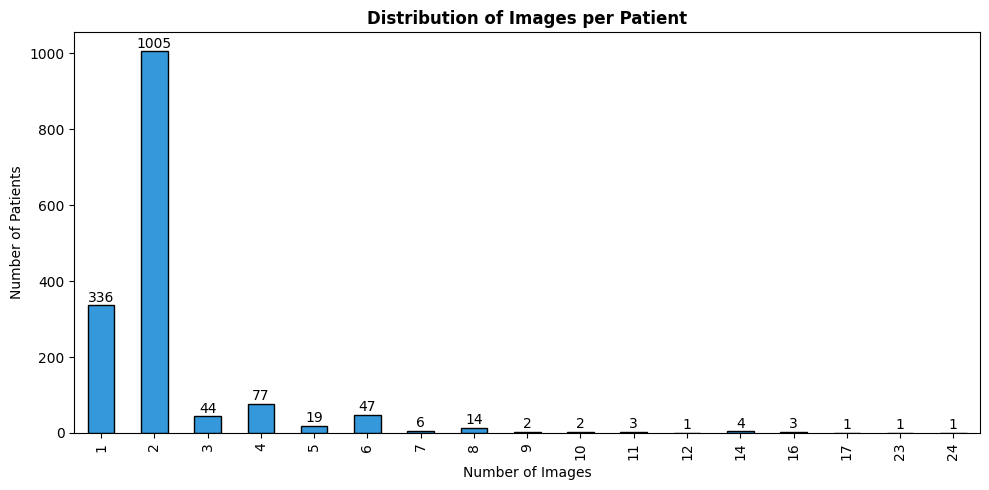

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
images_per_patient.value_counts().sort_index().plot(kind='bar', ax=ax, color='#3498db', edgecolor='black')
ax.set_title('Distribution of Images per Patient', fontsize=12, fontweight='bold')
ax.set_xlabel('Number of Images')
ax.set_ylabel('Number of Patients')
for i, v in enumerate(images_per_patient.value_counts().sort_index().values):
    ax.text(i, v + 2, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.show()

## Image Extraction

The originally DDSM images where distributed in an obselete JPEG form called LJPEG. Which apparently the only library capable of decompressing with "last updated in 1993".

They modified the original codec, and then extract the raw pixels, converting them into 16-bit DICOM format, which is the standard for medical images. The extraction is entirely lossless, although the fact that the original images are scans and not some more sophistocated like Full-Field Digital Mammography (as in the case of other datasets like InBreast), will limit the capability of DDSM somewhat.


